In [1]:
import numpy as np
import matplotlib.pylab as plt
import blimpy as bl
%matplotlib inline

In [2]:
from typing import List, Tuple

from astropy.time import Time
from astropy import units as u

In [3]:
import qrcode
from PIL import Image

In [4]:
MAX_IMSHOW_POINTS   = (8192, 4096 / 8)           # Max number of points in imshow plot


def plot_waterfall(fil, f_start=None, f_stop=None, if_id=0, 
                   logged=True, cb=False, freq_label=False, MJD_time=False, **kwargs):
    """ Plot waterfall of data
    Args:
        f_start (float): start frequency, in MHz
        f_stop (float): stop frequency, in MHz
        logged (bool): Plot in linear (False) or dB units (True),
        cb (bool): for plotting the colorbar
        kwargs: keyword args to be passed to matplotlib imshow()
    """


    plt.rc('font', size=12)

    plot_f, plot_data = fil.grab_data(f_start, f_stop, if_id)

    # Make sure waterfall plot is under 4k*4k
    dec_fac_x, dec_fac_y = 1, 1
    if plot_data.shape[0] > MAX_IMSHOW_POINTS[0]:
        dec_fac_x = plot_data.shape[0] / MAX_IMSHOW_POINTS[0]

    if plot_data.shape[1] > MAX_IMSHOW_POINTS[1]:
        dec_fac_y =  plot_data.shape[1] /  MAX_IMSHOW_POINTS[1]

    #print(dec_fac_x)
        
    plot_data = bl.utils.rebin(plot_data, int(dec_fac_x), int(dec_fac_y))
    
    plot_data = np.fliplr(plot_data)
    plot_f = np.flipud(plot_f)

    if MJD_time:
        extent=(plot_f[0], plot_f[-1], fil.timestamps[-1], fil.timestamps[0])
    else:
        extent=(plot_f[0], plot_f[-1], (fil.timestamps[-1]-fil.timestamps[0])*24.*60.*60, 0.0)

    this_plot = plt.imshow(plot_data,
        aspect='auto',
        rasterized=True,
        interpolation='nearest',
        extent=extent,
        cmap='hot',
        **kwargs
    )
    if cb:
        plt.colorbar()

    if freq_label:
        plt.xlabel("Frequency (Hz)", size=12)
    if MJD_time:
        plt.ylabel("Time (MJD)", size=12)
    else:
        plt.ylabel("Time (s)", size=12)


#    print('this is plot_data:', plot_data)
#    print('this is plot_data\'s shape:', plot_data.shape)
#    print('this is plot_f:', plot_f)
#    print('this is plot_f\'s shape', plot_f.shape)
    
    return this_plot

def make_waterfall_plots(filenames_list, target, f_start, f_stop, ion=False, correction_in=0, 
                         line1=None, line2=None, **kwargs):
    ''' Makes waterfall plots per group of ON-OFF pairs (up to 6 plots.)
    '''

    plt.rc('font', size=12)

    if ion:
        plt.ion()

#    n_plots = len(filenames_list)
#    fig = plt.subplots(n_plots, sharex=True, sharey=True)
#    fig = plt.subplots(n_plots, sharex=True, sharey=True, figsize=(10, 2*n_plots))
#    fig = plt.subplots(1, 2, 1, sharex=True, sharey=True)

    fil = bl.Waterfall(filenames_list[0], f_start=f_start, f_stop=f_stop)
    
    A1_avg = np.median(fil.data)
    A1_max = fil.data.max()
    A1_std = np.std(fil.data)

    labeling = ['A','B','A','C','A','D']

    delta_f = np.abs(f_start-f_stop)
    mid_f = np.abs(f_start+f_stop)/2.
    
    #Adjust the incorrect header data
    correction = mid_f - correction_in
    mid_f_text = mid_f - correction

    for i,filename in enumerate(filenames_list):
        plt.subplot(grid[i + 6, :])

        fil = bl.Waterfall(filename, f_start=f_start, f_stop=f_stop)

        this_plot = plot_waterfall(fil,f_start=f_start, f_stop=f_stop,
                                   vmin=A1_avg-A1_std*0,vmax=A1_avg+5.*A1_std,**kwargs)
        
        if line1 != None:
            plt.axvline(x=line1, color = 'white', ls='--')
        if line2 != None:
            plt.axvline(x=line2, color = 'white', ls='--')

        if i == 0:
            plt.title('Waterfall plot', size=13.5)

        if i < len(filenames_list)-1:
            plt.xticks(np.arange(f_start, f_stop, delta_f/4.), ['','','',''])

    #Some plot formatting.
    ax = plt.gca()
    #ax.invert_xaxis()
    ax.get_xaxis().get_major_formatter().set_useOffset(False)
    
    if target == 'HIP7981':
        #f_start -= 0.3
        #f_stop  += 0.3
        factor = 1e3
        units = 'kHz'
    else:
        factor = 1e6
        units = 'Hz'
    
    plt.xticks(np.arange(f_start, f_stop + 0.1 * delta_f/4, delta_f/4),
               [round(loc_freq) for loc_freq in np.arange(
                   (f_start-mid_f), (f_stop+0.1*delta_f/4-mid_f), delta_f/4)*factor])
    plt.xlabel("Relative frequency in %s from %f MHz"%(units, mid_f), size=12)
    

    #to plot color bar. for now.
#     fig = plt.subplots(6, sharex=True, sharey=True)
#     cax = fig[0].add_axes([0.9, 0.12, 0.03, 0.75])
#     fig[0].colorbar(this_plot,cax=cax,label='Power (Arbitrary Units)')

    # Fine-tune figure; make subplots close to each other and hide x ticks for
    # all but bottom plot.
#    plt.subplots_adjust(hspace=0,wspace=0)

In [5]:
grid = plt.GridSpec(12, 6, wspace=1, hspace=0.1)

In [6]:
MAX_IMSHOW_POINTS   = (8192, 4096 / 8)           # Max number of points in imshow plot


def plot_waterfall(fil, f_start=None, f_stop=None, if_id=0, 
                   logged=True, cb=False, freq_label=False, MJD_time=False, **kwargs):
    """ Plot waterfall of data
    Args:
        f_start (float): start frequency, in MHz
        f_stop (float): stop frequency, in MHz
        logged (bool): Plot in linear (False) or dB units (True),
        cb (bool): for plotting the colorbar
        kwargs: keyword args to be passed to matplotlib imshow()
    """


    plt.rc('font', size=12)

    plot_f, plot_data = fil.grab_data(f_start, f_stop, if_id)

    # Make sure waterfall plot is under 4k*4k
    dec_fac_x, dec_fac_y = 1, 1
    if plot_data.shape[0] > MAX_IMSHOW_POINTS[0]:
        dec_fac_x = plot_data.shape[0] / MAX_IMSHOW_POINTS[0]

    if plot_data.shape[1] > MAX_IMSHOW_POINTS[1]:
        dec_fac_y =  plot_data.shape[1] /  MAX_IMSHOW_POINTS[1]

    #print(dec_fac_x)
        
    plot_data = bl.utils.rebin(plot_data, int(dec_fac_x), int(dec_fac_y))
    
    plot_data = np.fliplr(plot_data)
    plot_f = np.flipud(plot_f)

    if MJD_time:
        extent=(plot_f[0], plot_f[-1], fil.timestamps[-1], fil.timestamps[0])
    else:
        extent=(plot_f[0], plot_f[-1], (fil.timestamps[-1]-fil.timestamps[0])*24.*60.*60, 0.0)

    this_plot = plt.imshow(plot_data,
        aspect='auto',
        rasterized=True,
        interpolation='nearest',
        extent=extent,
        cmap='hot',
        **kwargs
    )
    if cb:
        plt.colorbar()

    if freq_label:
        plt.xlabel("Frequency (Hz)")
    if MJD_time:
        plt.ylabel("Time (MJD)")
    else:
        plt.ylabel("Time (s)")


#    print('this is plot_data:', plot_data)
#    print('this is plot_data\'s shape:', plot_data.shape)
#    print('this is plot_f:', plot_f)
#    print('this is plot_f\'s shape', plot_f.shape)
    
    return this_plot

def make_waterfall_plots(filenames_list, target, f_start, f_stop, ion=False, correction_in=0, 
                         line1=None, line2=None, **kwargs):
    ''' Makes waterfall plots per group of ON-OFF pairs (up to 6 plots.)
    '''

    plt.rc('font', size=12)

    if ion:
        plt.ion()

#    n_plots = len(filenames_list)
#    fig = plt.subplots(n_plots, sharex=True, sharey=True)
#    fig = plt.subplots(n_plots, sharex=True, sharey=True, figsize=(10, 2*n_plots))
#    fig = plt.subplots(1, 2, 1, sharex=True, sharey=True)

    fil = bl.Waterfall(filenames_list[0], f_start=f_start, f_stop=f_stop)
    
    A1_avg = np.median(fil.data)
    A1_max = fil.data.max()
    A1_std = np.std(fil.data)

    labeling = ['A','B','A','C','A','D']

    delta_f = np.abs(f_start-f_stop)
    mid_f = np.abs(f_start+f_stop)/2.
    
    #Adjust the incorrect header data
    correction = mid_f - correction_in
    mid_f_text = mid_f - correction

    for i,filename in enumerate(filenames_list):
        plt.subplot(grid[i + 6, :])

        fil = bl.Waterfall(filename, f_start=f_start, f_stop=f_stop)

        this_plot = plot_waterfall(fil,f_start=f_start, f_stop=f_stop,
                                   vmin=A1_avg-A1_std*0,vmax=A1_avg+5.*A1_std,**kwargs)
        
        if line1 != None:
            plt.axvline(x=line1, color = 'white', ls='--')
        if line2 != None:
            plt.axvline(x=line2, color = 'white', ls='--')

        if i == 0:
            plt.title('Waterfall plot')

        if i < len(filenames_list)-1:
            plt.xticks(np.arange(f_start, f_stop, delta_f/4.), ['','','',''])

    #Some plot formatting.
    ax = plt.gca()
    #ax.invert_xaxis()
    ax.get_xaxis().get_major_formatter().set_useOffset(False)
    
    if target == 'HIP7981':
        #f_start -= 0.3
        #f_stop  += 0.3
        factor = 1e3
        units = 'kHz'
    else:
        factor = 1e6
        units = 'Hz'
    
    plt.xticks(np.arange(f_start, f_stop + 0.1 * delta_f/4, delta_f/4),
               [round(loc_freq) for loc_freq in np.arange(
                   (f_start-mid_f), (f_stop+0.1*delta_f/4-mid_f), delta_f/4)*factor])
    plt.xlabel("Relative frequency in %s from %f MHz"%(units, mid_f))
    

    #to plot color bar. for now.
#     fig = plt.subplots(6, sharex=True, sharey=True)
#     cax = fig[0].add_axes([0.9, 0.12, 0.03, 0.75])
#     fig[0].colorbar(this_plot,cax=cax,label='Power (Arbitrary Units)')

    # Fine-tune figure; make subplots close to each other and hide x ticks for
    # all but bottom plot.
#    plt.subplots_adjust(hspace=0,wspace=0)

In [7]:
def make_waterfall_plots_full(filenames_list, target, f_start, f_stop, ion=False, correction_in=0, 
                              line1=None, line2=None, **kwargs):
    ''' Makes waterfall plots per group of ON-OFF pairs (up to 6 plots.)
    '''

    plt.rc('font', size=12)

    if ion:
        plt.ion()

    n_plots = len(filenames_list)
#    fig = plt.subplots(n_plots, sharex=True, sharey=True)
#    fig = plt.subplots(n_plots, sharex=True, sharey=True, figsize=(10, 2*n_plots))
#    fig = plt.subplots(1, 2, 1, sharex=True, sharey=True)

    fil = bl.Waterfall(filenames_list[0], f_start=f_start, f_stop=f_stop)
    
    A1_avg = np.median(fil.data)
    A1_max = fil.data.max()
    A1_std = np.std(fil.data)

    labeling = ['A','B','A','C','A','D']

    delta_f = np.abs(f_start-f_stop)
    mid_f = np.abs(f_start+f_stop)/2.
    
    #Adjust the incorrect header data
    correction = mid_f - correction_in
    mid_f_text = mid_f - correction

    for i,filename in enumerate(filenames_list):
        plt.subplot(n_plots, 1, i + 1)

        fil = bl.Waterfall(filename, f_start=f_start, f_stop=f_stop)

        this_plot = plot_waterfall(fil,f_start=f_start, f_stop=f_stop,
                                   vmin=A1_avg-A1_std*0,vmax=A1_avg+5.*A1_std,**kwargs)
        
        if line1 != None:
            plt.axvline(x=line1, color = 'white', ls='--')
        if line2 != None:
            plt.axvline(x=line2, color = 'white', ls='--')

##        if i == 0:
##            plt.title('Waterfall')

        if i < len(filenames_list)-1:
            plt.xticks(np.arange(f_start, f_stop, delta_f/4.), ['','','',''])

    #Some plot formatting.
    ax = plt.gca()
    #ax.invert_xaxis()
    ax.get_xaxis().get_major_formatter().set_useOffset(False)
    
    if target == 'HIP7981':
        #f_start -= 0.3
        #f_stop  += 0.3
        factor = 1e3
        units = 'kHz'
    else:
        factor = 1e6
        units = 'Hz'
    
    plt.xticks(np.arange(f_start, f_stop + 0.1 * delta_f/4, delta_f/4),
               [round(loc_freq) for loc_freq in np.arange(
                   (f_start-mid_f), (f_stop+0.1*delta_f/4-mid_f), delta_f/4)*factor])
    plt.xlabel("Relative frequency in %s from %f MHz"%(units, mid_f))
    

    #to plot color bar. for now.
#    cax = fig[0].add_axes([0.9, 0.12, 0.03, 0.75])
#    fig[0].colorbar(this_plot,cax=cax,label='Power (Arbitrary Units)')

    # Fine-tune figure; make subplots close to each other and hide x ticks for
    # all but bottom plot.
#    plt.subplots_adjust(hspace=0,wspace=0)

In [8]:
TELESCOPE = 'GBT'
OBS_TIME = '300s x 3'

In [9]:
all_targets = []

f = open('result_BLPC2_filenames.txt', 'r')
text = f.read().split()
f.close()

for word in text:
    if 'directory' not in word and 'stats' not in word and '.csv' in word:
        all_targets.append(word[:-4])

In [10]:
all_targets

['GJ166-1623',
 'GJ280-1616',
 'GJ699-1625',
 'GJ699_OFF-1626',
 'GJ725-1348',
 'HIP101093-2028',
 'HIP101180-2029',
 'HIP101262-2016',
 'HIP101382-2030',
 'HIP102101-2031',
 'HIP102253-2032',
 'HIP10279-1762',
 'HIP10279_OFF-1763',
 'HIP102805-2015',
 'HIP102851-2139',
 'HIP103800-2018',
 'HIP103800-2023',
 'HIP104521-2140',
 'HIP106147-2141',
 'HIP107350-1698',
 'HIP107350_OFF-1699',
 'HIP107556-1700',
 'HIP107556_OFF-1701',
 'HIP107788-1702',
 'HIP107788_OFF-1703',
 'HIP112496-1704',
 'HIP112496_OFF-1705',
 'HIP112774-1739',
 'HIP112774_OFF-1740',
 'HIP112870-1741',
 'HIP112870_OFF-1742',
 'HIP112918-1743',
 'HIP112918_OFF-1744',
 'HIP112935-1745',
 'HIP112935_OFF-1746',
 'HIP113829-2022',
 'HIP11452-1646',
 'HIP11452_OFF-1647',
 'HIP114622-1349',
 'HIP116215-2154',
 'HIP116215-2156',
 'HIP117197-2049',
 'HIP117197-2050',
 'HIP117197-2051',
 'HIP117197-2052',
 'HIP117779-2153',
 'HIP117779-2155',
 'HIP11783-1648',
 'HIP11783_OFF-1649',
 'HIP117946-1350',
 'HIP12114-1638',
 'HIP12114

In [11]:
print(len(all_targets))

289


In [12]:
def get_cadence(target_name: str) -> List[str]:
    
    cadence = []
    
    filename = 'result_BLPC2/' + target_name + '_directory.csv'
        
    f = open(filename, 'r')

    lines = f.readlines()
    f.close()

    for line in lines[1:]:
        info = line.strip().split(',')
        h5file = info[1][12:]
        cadence.append(h5file)
    
    return cadence

In [13]:
def get_hits(target_name: str) -> List[List[float]]:
    
    hits = []

    filename = 'result_BLPC2/' + target_name + '.csv'
    f = open(filename, 'r')

    lines = f.readlines()
    f.close()

    for line in lines[1:]:
        info = line.strip().split(',')
        start = float(info[1])
        stop = float(info[2])
        fit = float(info[3])
        hits.append([start, stop, fit])

    return hits

In [14]:
class Target:
    
    
    def __init__(self, target_name: str) -> None:
        
        name = target_name.split('-')[0]
        
        self.name = name
        self.cadence = get_cadence(target_name)
        self.hits = get_hits(target_name)
        self.num_hits = len(self.hits)
    
    def __str__(self) -> str:
        
        if self.num_hits == 1:
            return 'Target {} with {} hit'.format(self.name, self.num_hits)
        
        return 'Target {} with {} hits'.format(self.name, self.num_hits)
    
    
    def get_cadence_type(self) -> str:
        
        if len(self.cadence) == 6:
        
            lst = []

            for i in range(len(self.cadence)):
                fb = bl.Waterfall(self.cadence[i], load_data=False)
                source = fb.header['source_name']
                lst.append(source)

            if lst[0] == lst[2] == lst[4]:
                
                if lst[1] == lst[3] == lst[5] \
                and lst[0] != lst[1]:
                    return 'ABABAB'
                          
                elif lst[1] != lst[3] and lst[1] != lst[5] and lst[3] != lst[5] \
                and lst[0] != lst[1] and lst[0] != lst[3] and lst[0] != lst[5]:
                    return 'ABACAD'
        
        return 'other'
    
    
    def get_RA(self) -> str:
        
        fb = bl.Waterfall(self.cadence[0], load_data=False)
        RA = fb.header['src_raj']
        
        return str(RA)
    
    
    def get_DEC(self) -> str:
        
        fb = bl.Waterfall(self.cadence[0], load_data=False)
        DEC = fb.header['src_dej']
        
        return str(DEC)
    
    
    def get_date_time(self, ISOT=True) -> str:
        
        fb = bl.Waterfall(self.cadence[0], load_data=False)
        mjd = fb.header['tstart']
        
        if ISOT:
            return Time(mjd, format='mjd').isot
        
        return str(mjd)
    
    
    def get_min_freq(self) -> str:
        
        fb = bl.Waterfall(self.cadence[0], load_data=False)
        
        if fb.header['foff'] < 0:
            min_freq = fb.container.f_start - fb.header['foff']
        else:
            min_freq = fb.container.f_start
        
        return str(min_freq) + ' MHz'
    

    def get_max_freq(self) -> str:
        
        fb = bl.Waterfall(self.cadence[0], load_data=False)
        
        if fb.header['foff'] < 0:
            max_freq = fb.container.f_stop

        else:
            max_freq = fb.container.f_stop - fb.header['foff']
        
        return str(max_freq) + ' MHz'

In [15]:
COLUMN = 52

In [16]:
class Hit:
    
    
    def __init__(self, target: Target, index: int) -> None:
        
        self.target = target
        self.target_name = target.name
        self.number = index + 1
        self.start_freq = target.hits[index][0]
        self.end_freq = target.hits[index][1]
        self.fit = target.hits[index][2]
    
    def __str__(self) -> str:
        
        return 'Hit {} of {} for target {}'.format(self.number, self.target.num_hits, self.target_name)
    
    
    def make_plot(self):
        
        plt.rc('font', size=12)
        
        mid_freqs_pink = []
        fits_pink = []
        
        for i in range(self.target.num_hits):

            mid_freq = (self.target.hits[i][0] + self.target.hits[i][1]) / 2
            fit = self.target.hits[i][2]
            
            mid_freqs_pink.append(mid_freq)
            fits_pink.append(fit)
        
        marker_size = 4 / (self.target.num_hits / 5000)
        
        plt.scatter(mid_freqs_pink, fits_pink, color='pink', marker='.', s=marker_size)
        
        mid = (self.start_freq + self.end_freq) / 2
        plt.plot(mid, self.fit, marker='o', color='red', ms=8)
        
        plot_start = float(self.target.get_min_freq()[:-4])
        plot_end = float(self.target.get_max_freq()[:-4])
        plt.xlim(plot_start, plot_end)
        
        plt.grid()
        plt.xlabel('Frequency (MHz)', size=12)
        plt.ylabel('Confidence', size=12)
        plt.title('Position of hit in target\'s frequency band', size=13.5)
        
    
    def get_ID(self, targets_list: List[str]) -> str:
        
        modified_list = []
        for element in targets_list:
            modified_list.append(element.split('-')[0])
        
        first = str(modified_list.index(self.target_name) + 1)
        second = str(self.number)
        
        ID = first.rjust(2, '0') + '-' + second.rjust(5, '0')
        
        return ID
        

    def print_info(self, targets_list: List[str]) -> None:
        
        s1 = 'Target name: ' + self.target_name
        s2 = 'Number of hits for this target: ' + str(self.target.num_hits)
        tab = ' ' * (COLUMN - len(s1))
        print(s1, tab, s2)
        
        s1 = 'Right ascension: ' + self.target.get_RA()
        s2 = 'Average number of hits per target: ' + str(round(avg_num_hits))
        tab = ' ' * (COLUMN - len(s1))
        print(s1, tab, s2)
        
        s1 = 'Declination: ' + self.target.get_DEC()
        print(s1)

        s1 = 'Telescope: ' + TELESCOPE
        print(s1)

        s1 = 'Observation start (MJD): ' + self.target.get_date_time(ISOT=False)
        s2 = '\t\tHit #' + str(self.number) + ' of ' + str(self.target.num_hits)
        tab = ' ' * (COLUMN - len(s1))
        print(s1, tab, s2)

        s1 = 'Observation start (ISOT): ' + self.target.get_date_time()
        s2 = 'Start frequency: ' + str(self.start_freq) + ' MHz'
        tab = ' ' * (COLUMN - len(s1))
        print(s1, tab, s2)
        
        s1 = 'Observing time: ' + OBS_TIME
        s2 = 'End frequency: ' + str(self.end_freq) + ' MHz'
        tab = ' ' * (COLUMN - len(s1))
        print(s1, tab, s2)
        
        s1 = 'Cadence: ' + self.target.get_cadence_type()
        s2 = 'Event bandwidth: ' + str((self.end_freq - self.start_freq) * 1e6) + ' Hz'
        tab = ' ' * (COLUMN - len(s1))
        print(s1, tab, s2)

        s1 = 'Min frequency: ' + self.target.get_min_freq()
        s2 = 'Confidence: ' + str(self.fit * 100) + '%'
        tab = ' ' * (COLUMN - len(s1))
        print(s1, tab, s2)

        s1 = 'Max frequency: ' + self.target.get_max_freq()
        s2 = 'Candidate ID: ' + self.get_ID(targets_list)
        tab = ' ' * (COLUMN - len(s1))
        print(s1, tab, s2)

        
    def get_text(self, targets_list: List[str]) -> Tuple[Tuple[str]]:
        
        s1 = 'Target name: '
        s2 = self.target_name
        s3 = 'Number of hits for this target: ' + str(self.target.num_hits)
        line1 = (s1, s2, s3)
        
        s1 = 'Right ascension: ' + self.target.get_RA()
        s2 = 'Average number of hits per target: ' + str(round(avg_num_hits))
        line2 = (s1, s2)
        
        s1 = 'Declination: ' + self.target.get_DEC()
        s2 = ''
        line3 = (s1, s2)

        s1 = 'Telescope: ' + TELESCOPE
        s2 = ''
        line4 = (s1, s2)

        s1 = 'Observation start (MJD): ' + self.target.get_date_time(ISOT=False)
        s2 = ' ' * 15 + 'Hit #' + str(self.number) + ' of ' + str(self.target.num_hits)
        line5 = (s1, s2)

        s1 = 'Observation start (ISOT): ' + self.target.get_date_time()
        s2 = 'Start frequency: ' + str(self.start_freq) + ' MHz'
        line6 = (s1, s2)
        
        s1 = 'Observing time: ' + OBS_TIME
        s2 = 'End frequency: ' + str(self.end_freq) + ' MHz'
        line7 = (s1, s2)
        
        s1 = 'Cadence: ' + self.target.get_cadence_type()
        s2 = 'Event bandwidth: ' + str((self.end_freq - self.start_freq) * 1e6) + ' Hz'
        line8 = (s1, s2)

        s1 = 'Min frequency: ' + self.target.get_min_freq()
        s2 = 'Confidence: ' + str(self.fit * 100) + '%'
        line9 = (s1, s2)

        s1 = 'Max frequency: ' + self.target.get_max_freq()
        s2 = 'Candidate ID: ' + self.get_ID(targets_list)
        line10 = (s1, s2)
        
        return (line1, line2, line3, line4, line5, line6, line7, line8, line9, line10)
    
    
    def generate_QR(self, targets_list: List[str]) -> None:
        
        line1 = 'Candidate ID: ' + self.get_ID(targets_list)
        line2 = 'Target name: ' + self.target_name
        line3 = 'Hit #' + str(self.number) + ' of ' + str(self.target.num_hits)
        
        message = line1 + '\n' + line2 + '\n' + line3
        
        img = qrcode.make(message)
        img.thumbnail((300, 300))

        return img

In [17]:
num_hits_per_target = []

for target_name in all_targets:
    n = Target(target_name).num_hits
    num_hits_per_target.append(n)

avg_num_hits = np.sum(num_hits_per_target) / len(all_targets)

In [18]:
tab = ' ' * (14 - len('Target index'))

print('Target index', tab, 'Number of hits')

for i, num in enumerate(num_hits_per_target):
    tab = ' ' * (14 - len(str(i)))
    print(i, tab, num)

Target index    Number of hits
0               1361
1               859
2               745
3               1268
4               1302
5               1152
6               1686
7               1406
8               899
9               1302
10              1207
11              1530
12              770
13              1015
14              1136
15              7197
16              1601
17              8971
18              1737
19              839
20              1091
21              1781
22              1194
23              860
24              1792
25              1500
26              1572
27              899
28              1153
29              1162
30              1168
31              990
32              991
33              624
34              1365
35              1737
36              1724
37              1303
38              1218
39              3064
40              1332
41              5691
42              4784
43              5281
44              3878
45              3020
46           

In [19]:
np.max(num_hits_per_target)

23935

In [31]:
def plot_highlighted_hist(target: Target):

    plt.rc('font', size=12)
    
    binning = np.arange(0, 25000, 1000)

    array, bins, patches = plt.hist(num_hits_per_target, bins=binning, color='gray')

    n = target.num_hits // 1000
    patches[n].set_fc('red')
    
#    plt.yticks(ticks=[0, 1, 2, 3, 4])
#    plt.xticks(ticks=np.arange(0, 4400, 400))

    plt.grid()
    plt.xlabel('Number of hits', size=12)
    plt.ylabel('Number of targets', size=12)
    plt.title('Hits per target', size=13.5)

In [21]:
def plot_all_hits(targets_list: List[str]):
        
    plt.rc('font', size=12)

    targets_min_freq = []
    targets_max_freq = []
    mid_freqs = []
    fits = []

    for target_name in targets_list:
        target = Target(target_name)

        min_freq = float(target.get_min_freq()[:-4])
        max_freq = float(target.get_max_freq()[:-4])
        targets_min_freq.append(min_freq)
        targets_max_freq.append(max_freq)

        for i in range(target.num_hits):

            mid_freq = (target.hits[i][0] + target.hits[i][1]) / 2
            fit = target.hits[i][2]

            mid_freqs.append(mid_freq)
            fits.append(fit)

    plt.scatter(mid_freqs, fits, color='red', marker='.', alpha=0.3, s=1)

    plot_start = min(targets_min_freq)
    plot_end = max(targets_max_freq)
    plt.xlim(plot_start, plot_end)

    plt.grid()
    plt.xlabel('Frequency (MHz)')
    plt.ylabel('Confidence')
    plt.title('Position of hit in the frequency band (all targets)')

In [22]:
def hist_all_hits(targets_list: List[str]):

    plt.rc('font', size=12)

    targets_min_freq = []
    targets_max_freq = []
    mid_freqs = []

    for target_name in targets_list:
        target = Target(target_name)

        min_freq = float(target.get_min_freq()[:-4])
        max_freq = float(target.get_max_freq()[:-4])
        targets_min_freq.append(min_freq)
        targets_max_freq.append(max_freq)

        for i in range(target.num_hits):

            mid_freq = (target.hits[i][0] + target.hits[i][1]) / 2
            mid_freqs.append(mid_freq)

    plot_start = min(targets_min_freq)
    plot_end = max(targets_max_freq)
    freq_bins = np.arange(plot_start, plot_end + 5, 5)

    plt.hist(mid_freqs, bins=freq_bins, color='red', edgecolor='black')

    plt.grid()
    plt.xlabel('Frequency (MHz)')
    plt.ylabel('Number of hits')
    plt.title('Hit distribution in the frequency band (all targets)')

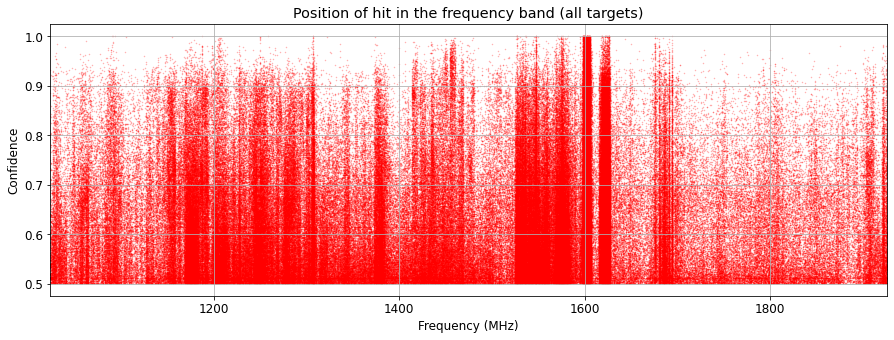

In [23]:
plot_all_hits(all_targets)

plt.gcf().set_size_inches(15, 5)    
plt.show()

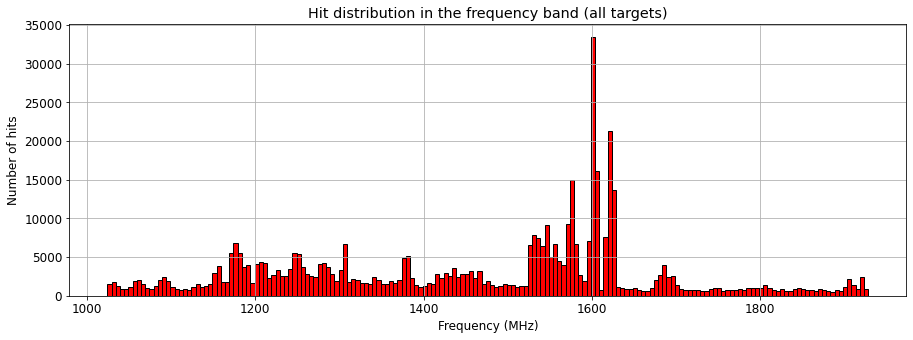

In [24]:
hist_all_hits(all_targets)

plt.gcf().set_size_inches(15, 5)    
plt.show()

In [25]:
def plot_everything(this_hit: Hit, targets_list: List[str]):
    
    
    plt.figure(figsize = (15, 20))


    plt.subplot(grid[:3, :5])

    plt.axis('off')
    
    plt.text(0.48, 1, 'Candidate information', size=15, fontweight='bold')

    spacing = 0.072
    text = this_hit.get_text(targets_list)

    for n, line in enumerate(text):
        
        if n == 0:
            plt.text(-0.05, 1 - spacing * (n + 2), line[0], size=13.5)
            plt.text(0.09, 1 - spacing * (n + 2), line[1], size=13.5, fontweight='bold')
            plt.text(0.55, 1 - spacing * (n + 2), line[2], size=13.5)

        else:
            plt.text(-0.05, 1 - spacing * (n + 2), line[0], size=13.5)
            if 'Hit' in line[1]:
                plt.text(0.55, 1 - spacing * (n + 2), line[1], size=13.5, fontweight='bold')
            else:
                plt.text(0.55, 1 - spacing * (n + 2), line[1], size=13.5)


    plt.subplot(grid[:3, 5])
    QR = this_hit.generate_QR(targets_list)
    plt.imshow(QR, cmap='gray')
    plt.axis('off')
    
    plt.subplot(grid[3:5, :3])
    plot_highlighted_hist(this_hit.target)


    plt.subplot(grid[3:5, 3:])
    this_hit.make_plot()


    diff = this_hit.end_freq - this_hit.start_freq
    start = this_hit.start_freq #- diff
    stop = this_hit.end_freq #+ diff
    mid = (start + stop) / 2

    make_waterfall_plots(filenames_list=this_hit.target.cadence, target=this_hit.target.name, 
                         f_start=start, f_stop=stop, correction_in=mid)

    #plt.show()

In [26]:
def plot_from_ID(targets_list: List[str]):
    
    ID = input('Enter Candidate ID (two numbers separated by a dash): ')
    i = int(ID.split('-')[0]) - 1
    j = int(ID.split('-')[1]) - 1
    
    input_target = Target(targets_list[i])
    input_hit = Hit(input_target, j)

    plot_everything(input_hit, targets_list)

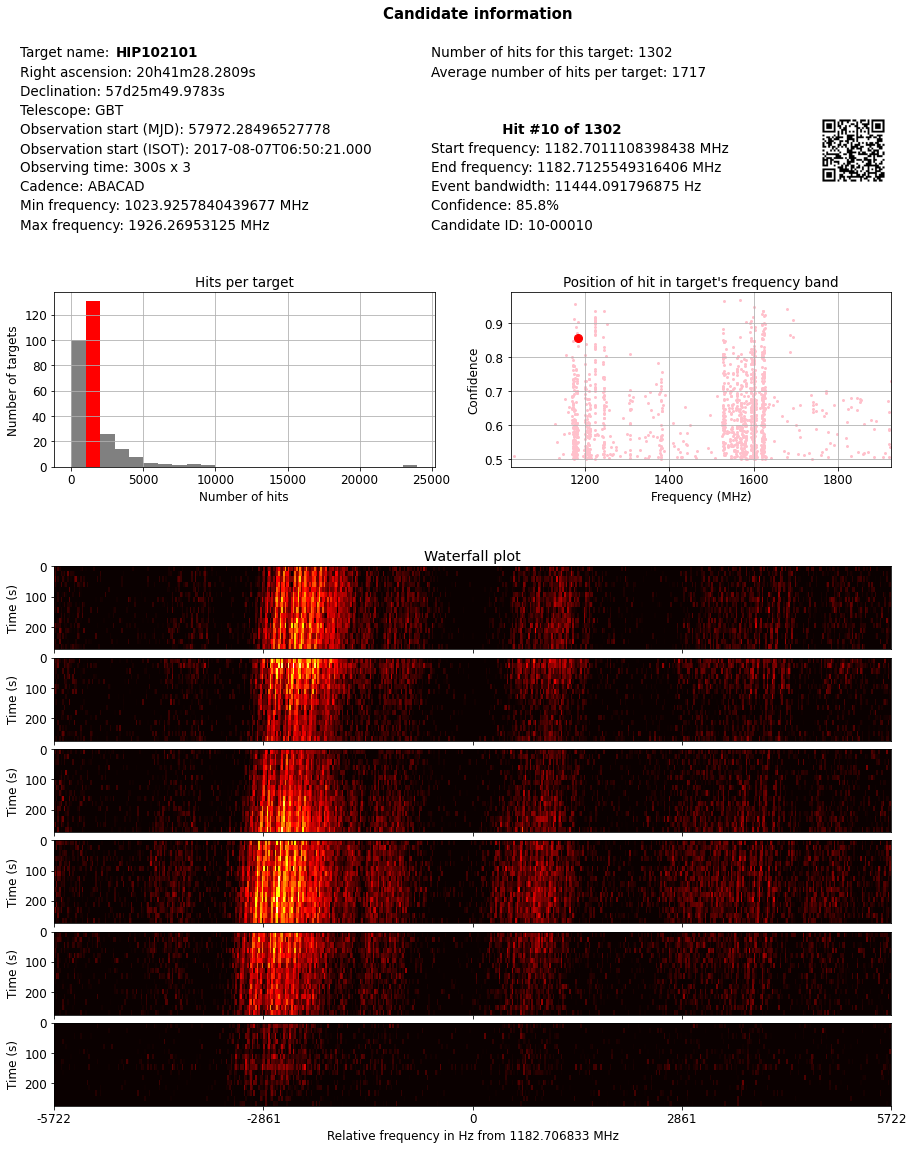

In [32]:
i = 9
j = 9

target = Target(all_targets[i])
hit = Hit(target, j)

plot_everything(hit, all_targets)

Enter Candidate ID (two numbers separated by a dash): 10-10


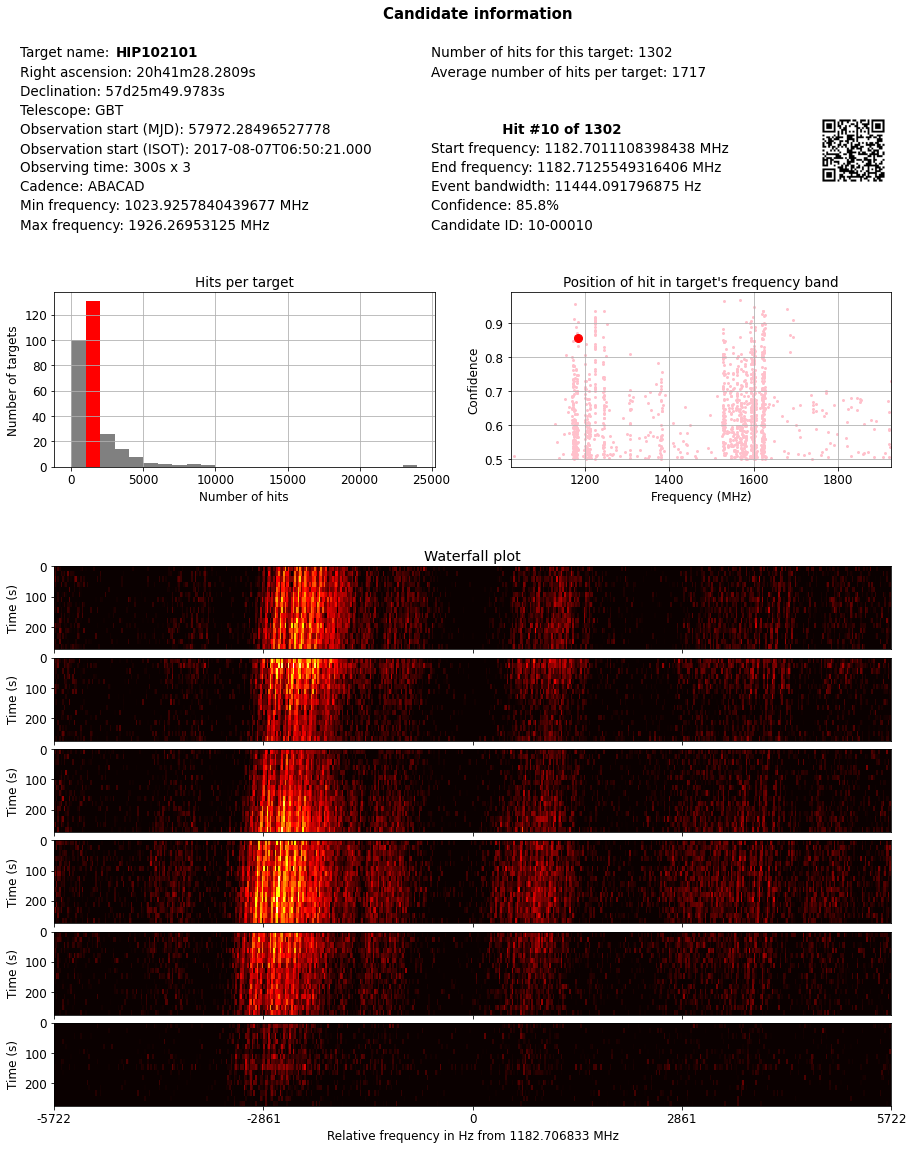

In [33]:
plot_from_ID(all_targets)

In [29]:
hitlist = []

#for i in range(len(all_targets)):
for i in [0]:
    target = Target(all_targets[i])
    
#    for j in range(target.num_hits):
    for j in range(10):
        hit = Hit(target, j)
        
        hitlist.append(hit)

matplotlib.animation INFO     Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
matplotlib.animation INFO     MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 432x288 -pix_fmt rgba -r 2.0 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y test.gif
matplotlib.animation WARNING  MovieWriter stderr:
[gif @ 0xec55c0] GIF muxer supports only a single video GIF stream.
Could not write header for output file #0 (incorrect codec parameters ?): Invalid argument



CalledProcessError: Command '['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '432x288', '-pix_fmt', 'rgba', '-r', '2.0', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-y', 'test.gif']' returned non-zero exit status 1.

<Figure size 432x288 with 0 Axes>

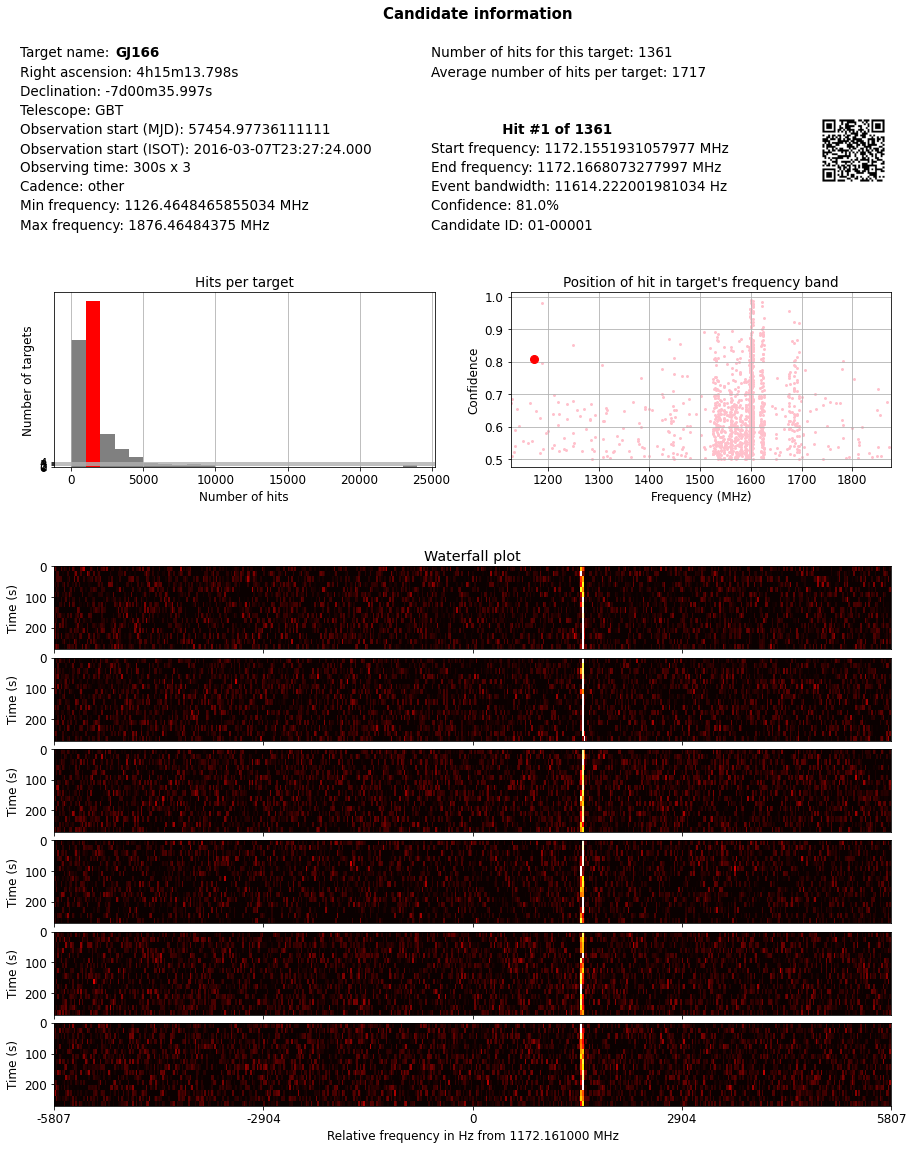

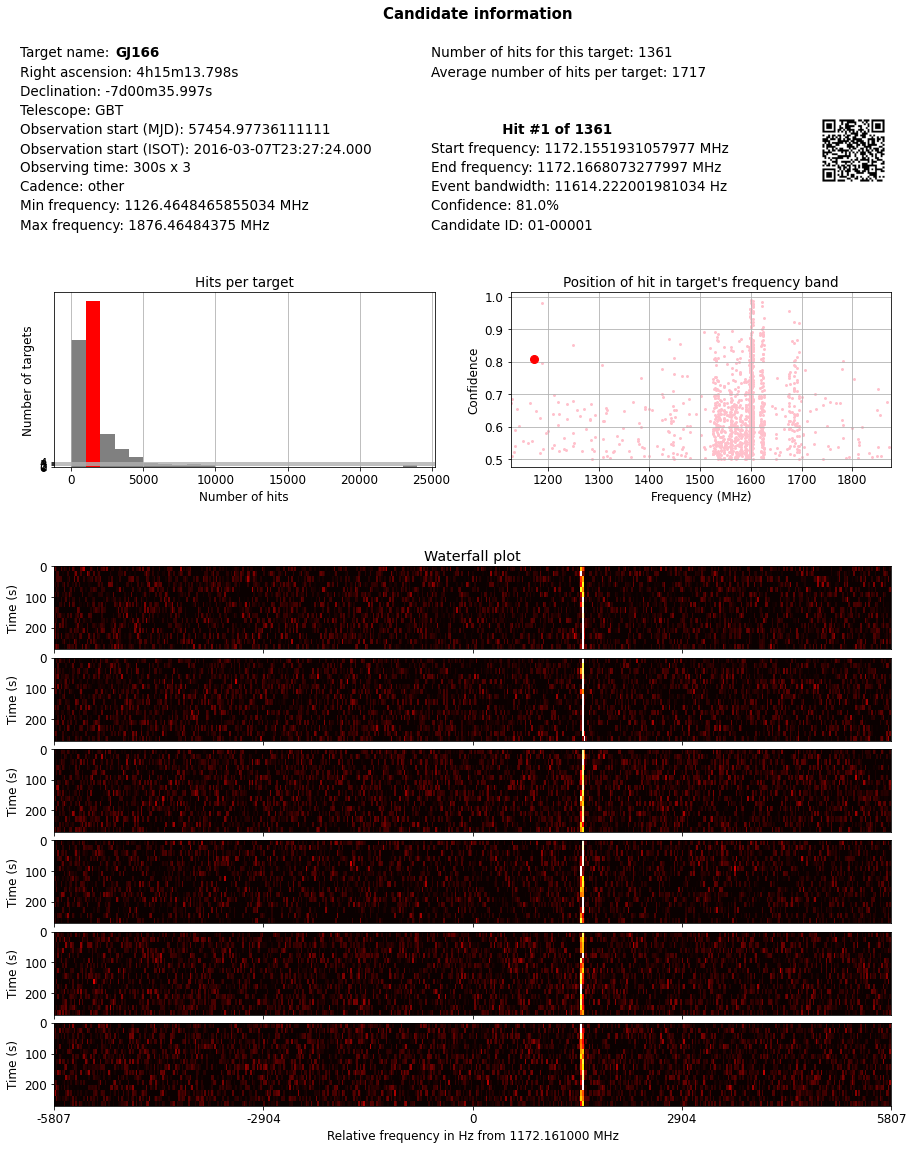

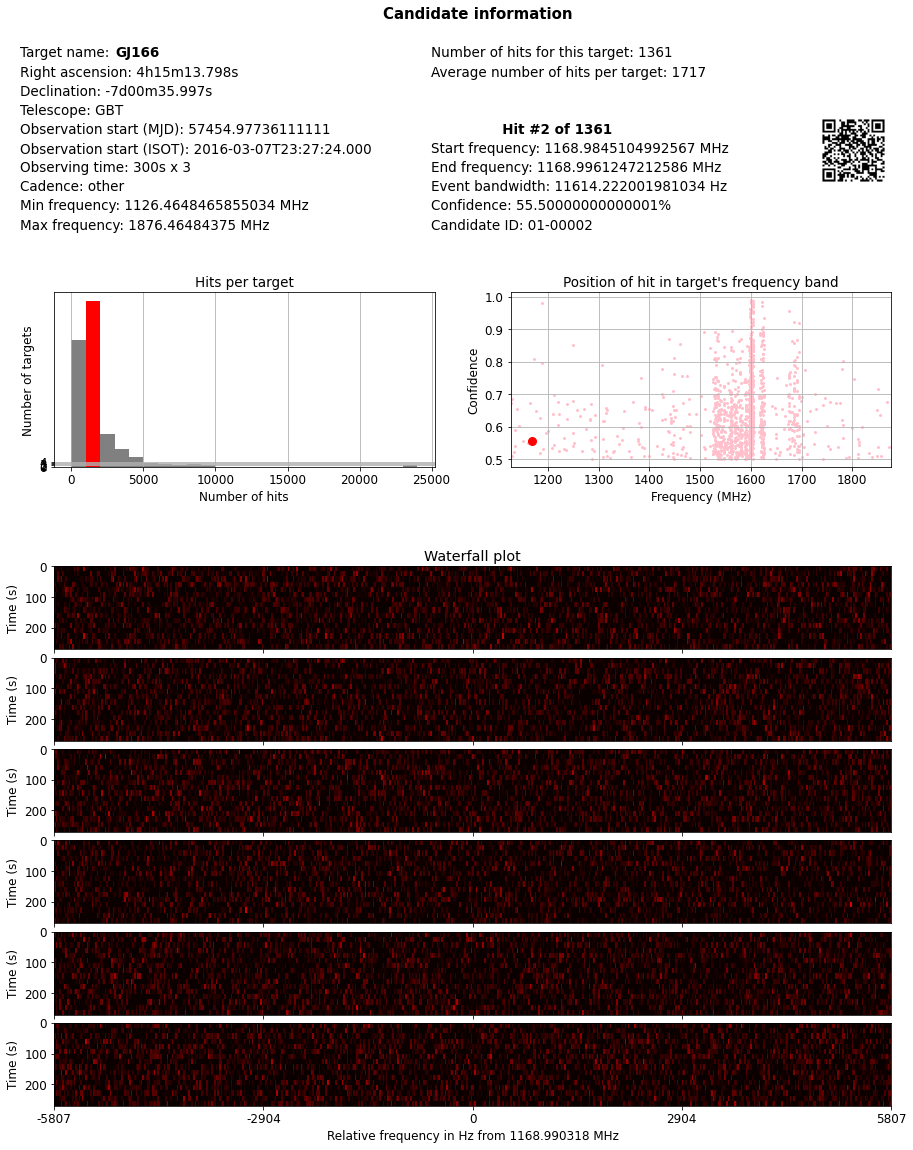

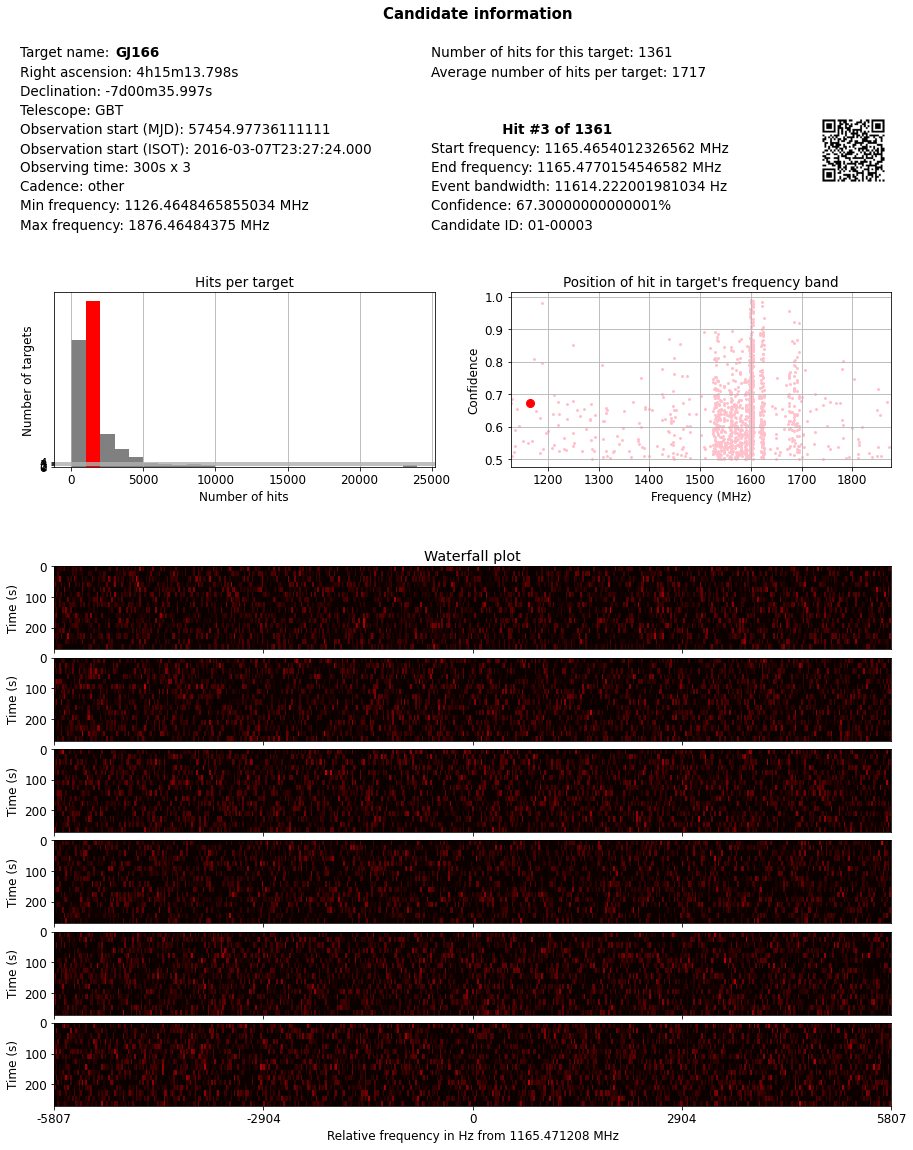

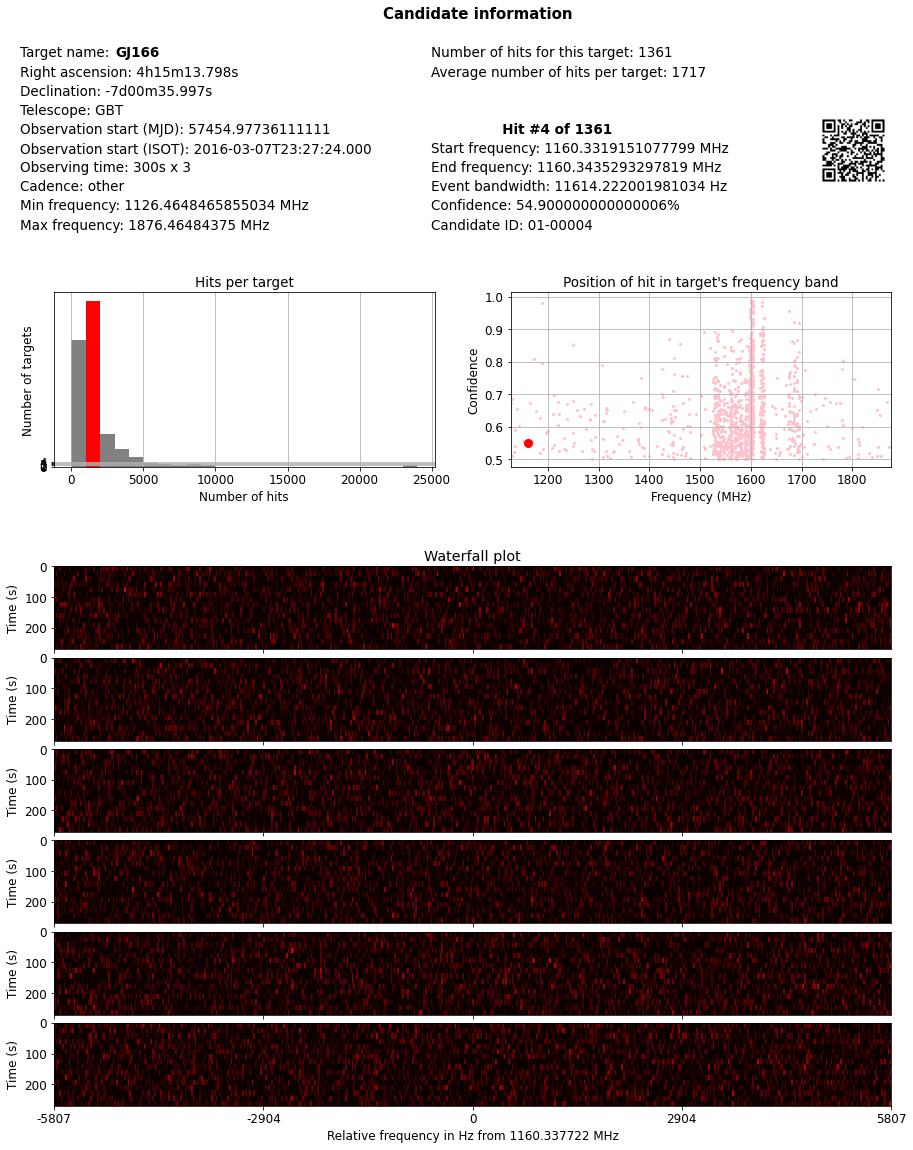

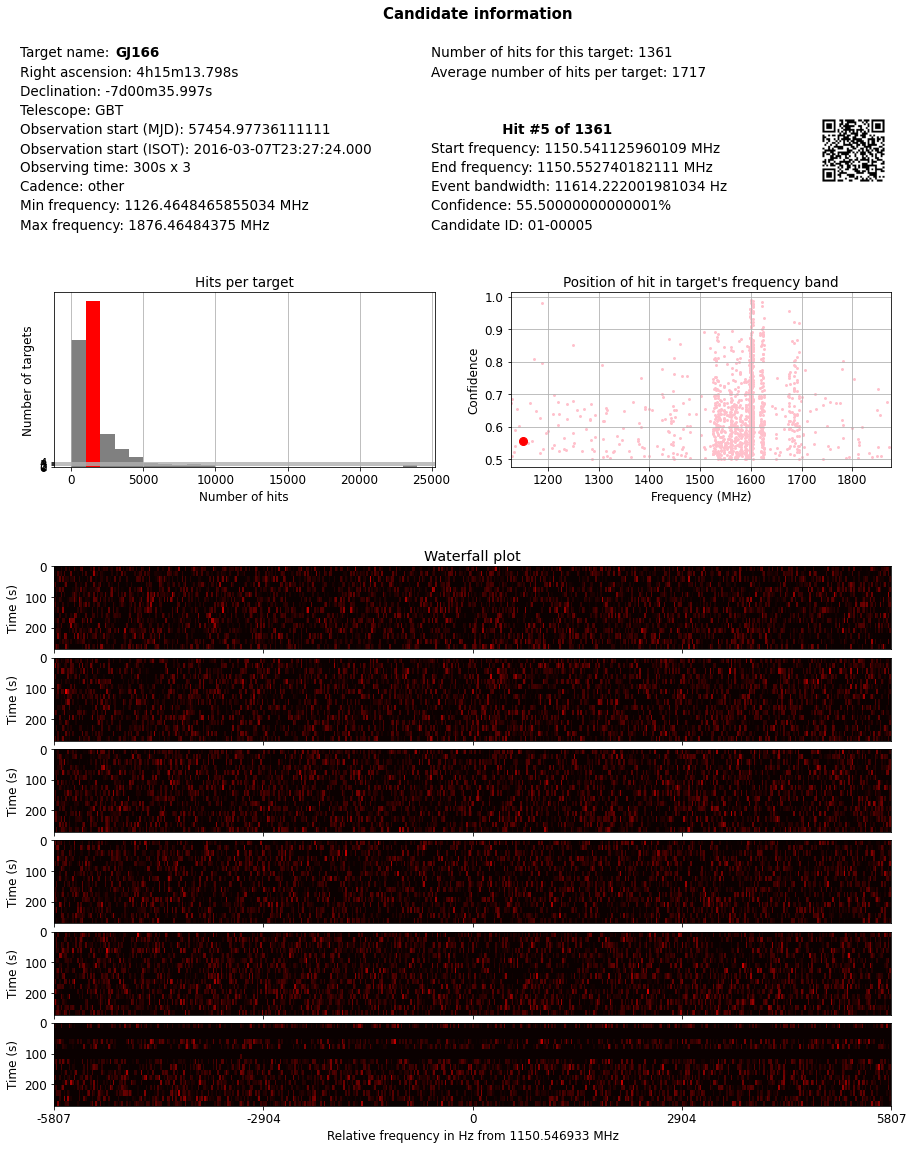

In [30]:
import matplotlib.animation as animation 

fig = plt.figure() 

def animate(t):
    
    hit = hitlist[t]
    plot_everything(hit, all_targets)
    
anim = animation.FuncAnimation(fig, animate, frames=5, interval=500)
anim.save('test.gif') 
#plt.show()

In [ ]:
import matplotlib.animation as animation 

fig = plt.figure()
ax = plt.axes()
line, = plot_everything([hitlist[0]], all_targets)

# initialization function: plot the background of each frame
def init():
    line.set_data(hitlist[0], all_targets)
    return line,

# animation function.  This is called sequentially
def animate(t):
    line.set_data(hitlist[t], all_targets)
    return line,

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=5, interval=20, blit=True)
#anim.save('test.gif')

In [ ]:
# To pick a target, redefine i or directly define target as the corresponding string:
i = 1
target = Target(all_targets[i])
#target = Target('HIP2')

In [ ]:
target.num_hits

In [ ]:
tab = ' ' * (10 - len('Hit index'))
j_list = []

print('Hit index', tab, 'Probability')
for j in range(len(target.hits)):
    if target.hits[j][2] > 0.9:
        tab = ' ' * (10 - len(str(j)))
        j_list.append(j)
        print(j, tab, target.hits[j][2])
print('\nlen =', len(j_list))

In [ ]:
k = 0

# To pick a hit, redefine j
j = j_list[k]
hit = Hit(target, j)

In [ ]:
tab = ' ' * (16 - len('Target number'))
print('Target number', tab, 'Number of 90% hits')

k_sum = 0

for i in range(len(all_targets)):
    target = Target(all_targets[i])
    
    k = 0
    for j in range(len(target.hits)):
        if target.hits[j][2] > 0.9:
            k += 1
            k_sum += 1
    
    tab = ' ' * (16 - len(str(i + 1)))
    print(i + 1, tab, k)

print('\nTotal number of 90% hits:', k_sum)

In [ ]:
# progress = 0

# for target_name in all_targets:
#     target = Target(target_name)
    
#     for j in range(len(target.hits)):
#         if target.hits[j][2] > 0.9:
#             hit = Hit(target, j)
        
#             ID = hit.get_ID(all_targets)
#             start = hit.start_freq
#             stop = hit.end_freq
#             mid = (start + stop) / 2

#             make_waterfall_plots_full(filenames_list=target.cadence, target=target.name, 
#                                       f_start=start, f_stop=stop, correction_in=mid)

#             plt.suptitle('Candidate ' + ID)
#             plt.gcf().set_size_inches(12, 6)    
#             plt.savefig('../Documents/waterfall_plots_BLPC2/candidate-' + ID)
#             plt.close()

#             progress += 1
#             print(progress, '/', k_sum, 'complete.')

In [ ]:
diff = hit.end_freq - hit.start_freq

start = hit.start_freq #- diff
stop = hit.end_freq #+ diff
mid = (start + stop) / 2

make_waterfall_plots_full(filenames_list=target.cadence, target=target.name, 
                          f_start=start, f_stop=stop, correction_in=mid)

plt.suptitle('Candidate ' + hit.get_ID(all_targets))
plt.gcf().set_size_inches(12, 6)  
plt.show()

In [ ]:
diff = hit.end_freq - hit.start_freq

start = hit.start_freq #- diff
stop = hit.end_freq #+ diff
mid = (start + stop) / 2

make_waterfall_plots_full(filenames_list=target.cadence, target=target.name, 
                          f_start=start, f_stop=stop, correction_in=mid)

plt.suptitle('Candidate ' + hit.get_ID(all_targets))
plt.gcf().set_size_inches(15, 10)    
plt.show()

In [ ]:
i = 1
j = 999

target = Target(all_targets[i])
hit = Hit(target, j)

plot_everything(hit, all_targets)

In [ ]:
print('\t\t\t\t\tCandidate information\n')

hit.print_info(all_targets)


diff = hit.end_freq - hit.start_freq

start = hit.start_freq #- diff
stop = hit.end_freq #+ diff
mid = (start + stop) / 2

make_waterfall_plots(filenames_list=target.cadence, target=target.name, 
                     f_start=start, f_stop=stop, correction_in=mid)


plt.subplot(2, 2, 2)
plot_highlighted_hist(target)

plt.subplot(2, 2, 4)
hit.make_plot()

plt.gcf().set_size_inches(15, 12)    
plt.show()

In [ ]:
print('\t\t\t\t\tCandidate information\n')

hit.print_info(all_targets)


diff = hit.end_freq - hit.start_freq

start = hit.start_freq #- diff
stop = hit.end_freq #+ diff
mid = (start + stop) / 2

make_waterfall_plots(filenames_list=target.cadence, target=target.name, 
                     f_start=start, f_stop=stop, correction_in=mid, 
                     line1=hit.start_freq, line2=hit.end_freq)


plt.subplot(2, 2, 2)
plot_highlighted_hist(target)

plt.subplot(2, 2, 4)
hit.make_plot()

plt.gcf().set_size_inches(15, 12)    
plt.show()

In [ ]:
print('\t\t\t\t\tCandidate information\n')

hit.print_info(all_targets)


diff = hit.end_freq - hit.start_freq

start = hit.start_freq - diff
stop = hit.end_freq + diff
mid = (start + stop) / 2

make_waterfall_plots(filenames_list=target.cadence, target=target.name, 
                     f_start=start, f_stop=stop, correction_in=mid, 
                     line1=hit.start_freq, line2=hit.end_freq)


plt.subplot(2, 2, 2)
plot_highlighted_hist(target)

plt.subplot(2, 2, 4)
hit.make_plot()

plt.gcf().set_size_inches(15, 12)    
plt.show()

In [ ]:
import qrcode
from PIL import Image

multi_paragraph = """
Leo Is the coolest intern I know 
"""


img = qrcode.make(multi_paragraph)
#img.save("sample.png")
img.thumbnail((150, 150))
img